In [1]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import time
from tqdm import tqdm

In [2]:
PATH_MAIN = "data"

files_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, 'images')))
files_imgs = [os.path.join(PATH_MAIN, 'images', f) for f in files_imgs]
files_masks = sorted(os.listdir(os.path.join(PATH_MAIN, 'masks')))
files_masks = [os.path.join(PATH_MAIN, 'masks', f) for f in files_masks]
files_keypoints = sorted(os.listdir(os.path.join(PATH_MAIN, 'keypoints')))
files_keypoints = [os.path.join(PATH_MAIN, 'keypoints', f) for f in files_keypoints]

print("The first five files from the sorted list of object images:", files_imgs[:5])
print("\nThe first five files from the sorted list of object masks:", files_masks[:5])
print("\nThe first five files from the sorted list of object keypoints:", files_keypoints[:5])

files_bg_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, 'bg')))
files_bg_imgs = [os.path.join(PATH_MAIN, 'bg', f) for f in files_bg_imgs]
# files_bg_noise_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, "bg_noise", "images")))
# files_bg_noise_imgs = [os.path.join(PATH_MAIN, "bg_noise", "images", f) for f in files_bg_noise_imgs]
# files_bg_noise_masks = sorted(os.listdir(os.path.join(PATH_MAIN, "bg_noise", "masks")))
# files_bg_noise_masks = [os.path.join(PATH_MAIN, "bg_noise", "masks", f) for f in files_bg_noise_masks]

print("\nThe first five files from the sorted list of background images:", files_bg_imgs[:5])
# print("\nThe first five files from the sorted list of background noise images:", files_bg_noise_imgs[:5])
# print("\nThe first five files from the sorted list of background noise masks:", files_bg_noise_masks[:5])


The first five files from the sorted list of object images: ['data/images/Clipped_image_20231015_123645.png', 'data/images/Clipped_image_20231015_123645_180.png', 'data/images/Clipped_image_20231015_123645_270.png', 'data/images/Clipped_image_20231015_123645_90.png', 'data/images/Clipped_image_20231015_123651.png']

The first five files from the sorted list of object masks: ['data/masks/Clipped_image_20231015_123645.png', 'data/masks/Clipped_image_20231015_123645_180.png', 'data/masks/Clipped_image_20231015_123645_270.png', 'data/masks/Clipped_image_20231015_123645_90.png', 'data/masks/Clipped_image_20231015_123651.png']

The first five files from the sorted list of object keypoints: ['data/keypoints/Clipped_image_20231015_123645.json', 'data/keypoints/Clipped_image_20231015_123645_180.json', 'data/keypoints/Clipped_image_20231015_123645_270.json', 'data/keypoints/Clipped_image_20231015_123645_90.json', 'data/keypoints/Clipped_image_20231015_123651.json']

The first five files from the

In [3]:
def get_img_and_mask(img_path, mask_path):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    mask_b = mask[:,:,0] == 0 # This is boolean mask
    mask = mask_b.astype(np.uint8) # This is binary mask
    
    return img, mask

In [4]:
def visualize_single_img_with_keypoints(img,
                                        mask,
                                        keypoints,
                                        keypoints_names, title,
                                        draw_bboxes=False):
    
    xmin = np.min(np.where(mask)[1])
    xmax = np.max(np.where(mask)[1])
    ymin = np.min(np.where(mask)[0])
    ymax = np.max(np.where(mask)[0])
    bbox = np.array([xmin, ymin, xmax, ymax])

    start_point = (bbox[0], bbox[1])
    end_point = (bbox[2], bbox[3])
    
    if draw_bboxes:
        img = cv2.rectangle(img.copy(), start_point, end_point, (255,0,0), 2)
    
    keypoints
    for idx, kp in enumerate(keypoints):
        img = cv2.circle(img.copy(), tuple(kp[:2]), 3, (255,0,0), 6)
        img = cv2.putText(img.copy(), " " + keypoints_names[idx], tuple(kp[:2]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
        
    plt.figure(figsize=(16,16))
    plt.title(title, fontsize=18)
    plt.imshow(img)

# keypoints_names = ['Head', 'Tail']
keypoints_names = ['TopLeft', 'TopRight', 'BottomLeft', 'BottomRight', 'Middle']

Image file: data/images/Clipped_image_20231015_123700_180.png
Mask file: data/masks/Clipped_image_20231015_123700_180.png

Shape of the image of the object: (1077, 908, 3)
Shape of the binary mask: (1077, 908)


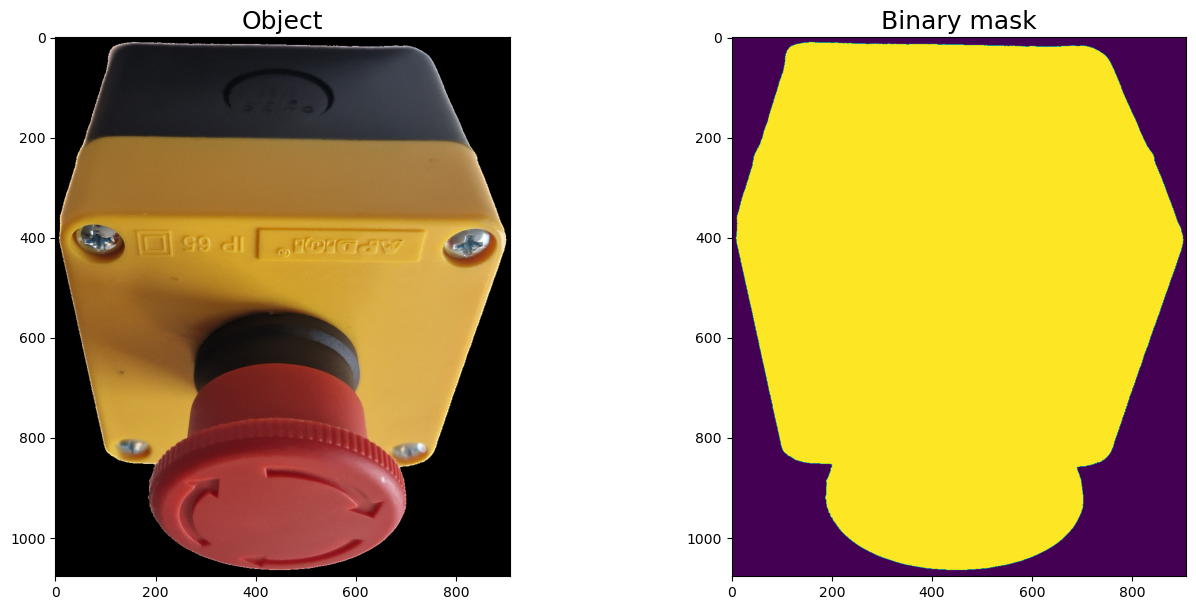

In [5]:
# Let's look at a random object and its binary mask

img_path = files_imgs[9]
mask_path = files_masks[9]

img, mask = get_img_and_mask(img_path, mask_path)

print("Image file:", img_path)
print("Mask file:", mask_path)
print("\nShape of the image of the object:", img.shape)
print("Shape of the binary mask:", mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img)
ax[0].set_title('Object', fontsize=18)
ax[1].imshow(mask)
ax[1].set_title('Binary mask', fontsize=18);

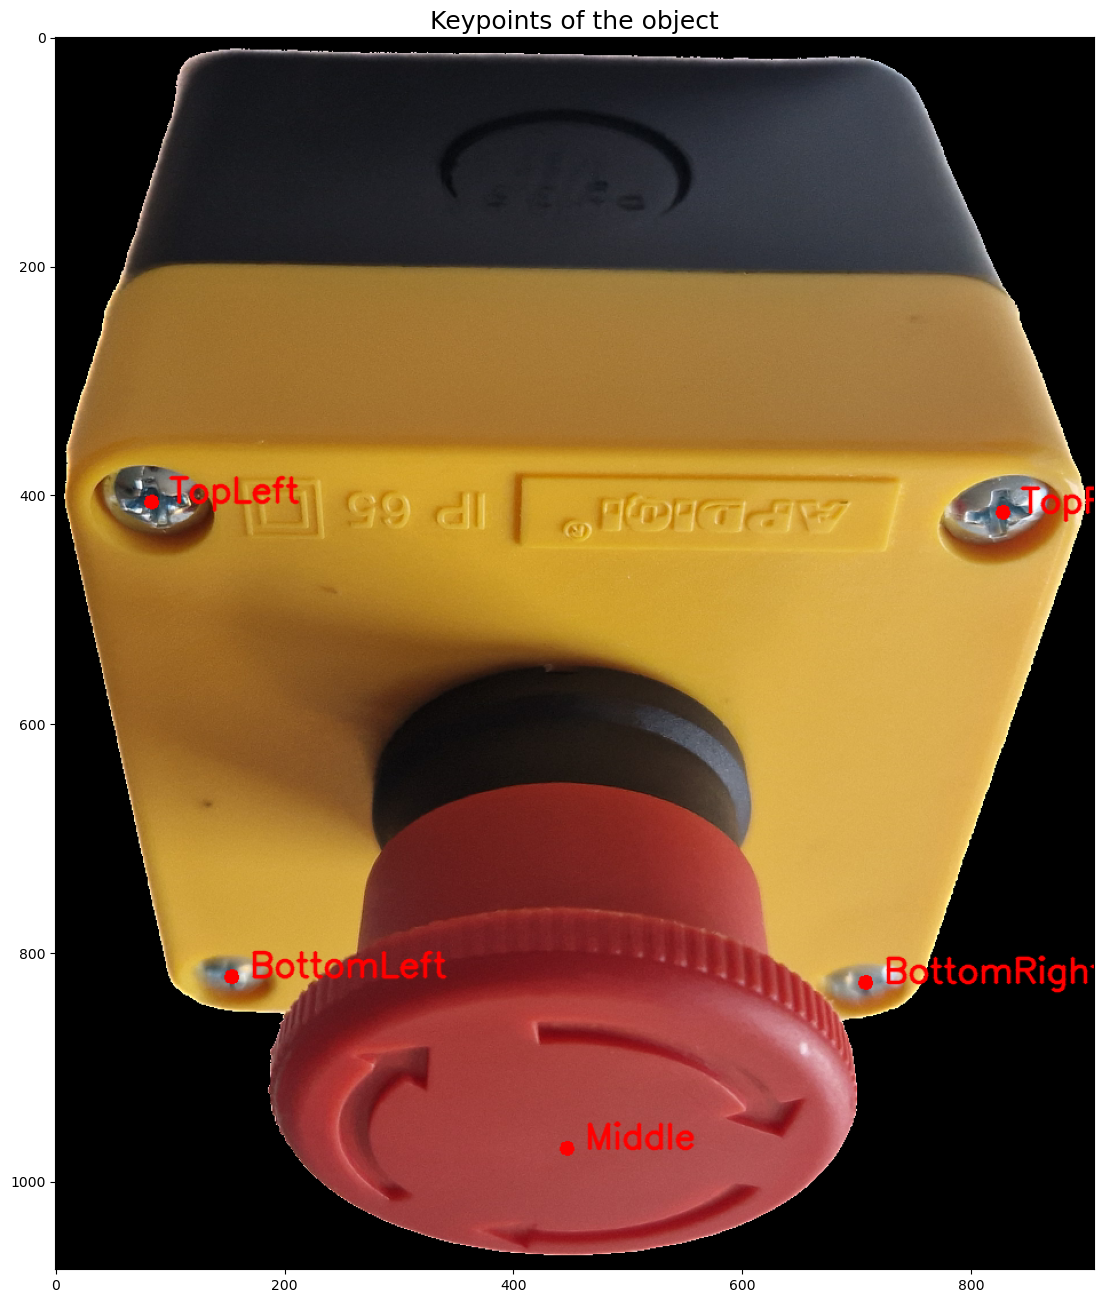

In [6]:
with open(files_keypoints[9]) as f:
    data = json.load(f)
    keypoints = data['keypoints']

visualize_single_img_with_keypoints(img, mask, keypoints, keypoints_names, title="Keypoints of the object")

In [7]:
def resize_img(img, desired_max, desired_min=None):
   
    h, w = img.shape[0], img.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = desired_max
    if desired_min:
        shortest_new = desired_min
    else:
        shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Compose([
        A.Sequential([
        A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)
        ], p=1)
    ])

    transformed = transform_resize(image=img)
    img_r = transformed["image"]
        
    return img_r

Shape of the original background image: (480, 640, 3)
Shape of the resized background image (desired_max=640, desired_min=None): (480, 640, 3)
Shape of the resized background image (desired_max=640, desired_min=480): (480, 640, 3)


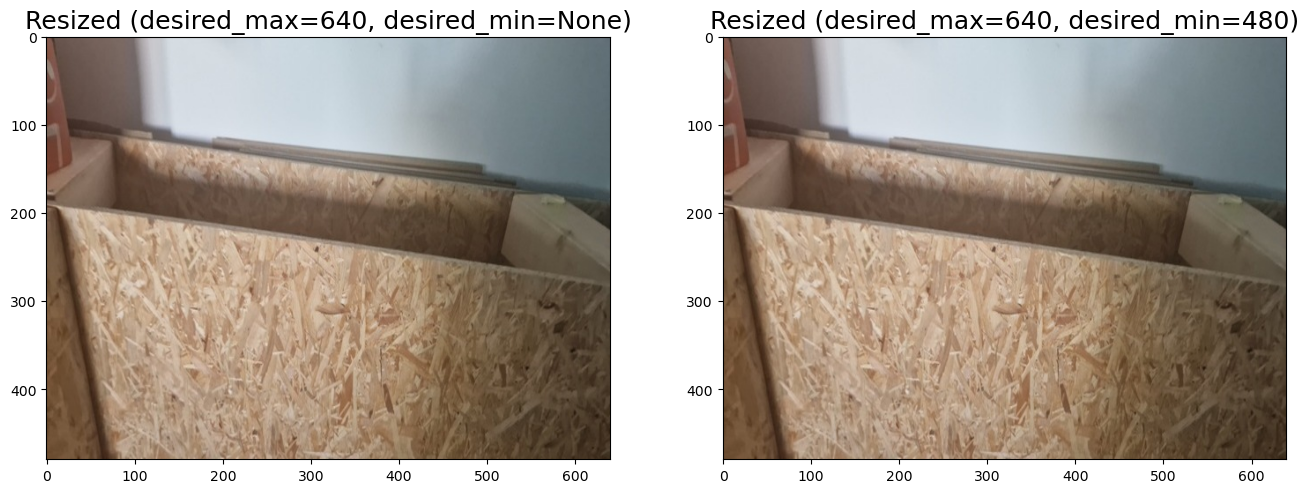

In [8]:
# Let's look how a random background image can be resized with resize_img() function

img_bg_path = files_bg_imgs[9]
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

img_bg_resized_1 = resize_img(img_bg, desired_max=640, desired_min=None)
img_bg_resized_2 = resize_img(img_bg, desired_max=640, desired_min=480)

print("Shape of the original background image:", img_bg.shape)

print("Shape of the resized background image (desired_max=640, desired_min=None):", img_bg_resized_1.shape)
print("Shape of the resized background image (desired_max=640, desired_min=480):", img_bg_resized_2.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_bg_resized_1)
ax[0].set_title('Resized (desired_max=640, desired_min=None)', fontsize=18)
ax[1].imshow(img_bg_resized_2)
ax[1].set_title('Resized (desired_max=640, desired_min=480)', fontsize=18);

In [9]:
def resize_transform_obj(img,
                         mask,
                         longest_min,
                         longest_max,
                         keypoints,
                         transforms=False):
   
    h, w = mask.shape[0], mask.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = np.random.randint(longest_min, longest_max)
    shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    keypoints_2 = [kp[0:2] for kp in keypoints]
        
    transform_resize = A.Compose([A.Resize(h_new,
                                           w_new,
                                           interpolation=1,
                                           always_apply=False,
                                           p=1)],
                                 keypoint_params=A.KeypointParams(format='xy'))
    
    transformed_resized = transform_resize(image=img,
                                           mask=mask,
                                           keypoints=keypoints_2)
    img_t = transformed_resized["image"]
    mask_t = transformed_resized["mask"]
    keypoints_2_t = transformed_resized["keypoints"]        

    if transforms:    
        transformed = transforms(image=img_t,
                                 mask=mask_t,
                                 keypoints=keypoints_2_t)
        img_t = transformed["image"]
        mask_t = transformed["mask"]
        keypoints_2_t = transformed["keypoints"]

    keypoints_t = []
    for idx, kp in enumerate(keypoints_2_t):
        keypoints_t.append(list(map(int, kp)) + [keypoints[idx][2]])       
        
    return img_t, mask_t, keypoints_t

transforms_obj = A.Compose([
    # A.RandomRotate90(p=1), # not allowed for us - skpawar1305
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                               contrast_limit=0.1,
                               brightness_by_max=True,
                               always_apply=False,
                               p=1)
],
keypoint_params=A.KeypointParams(format='xy'))


Shape of the image of the transformed object: (407, 343, 3)
Shape of the transformed binary mask: (407, 343, 3)


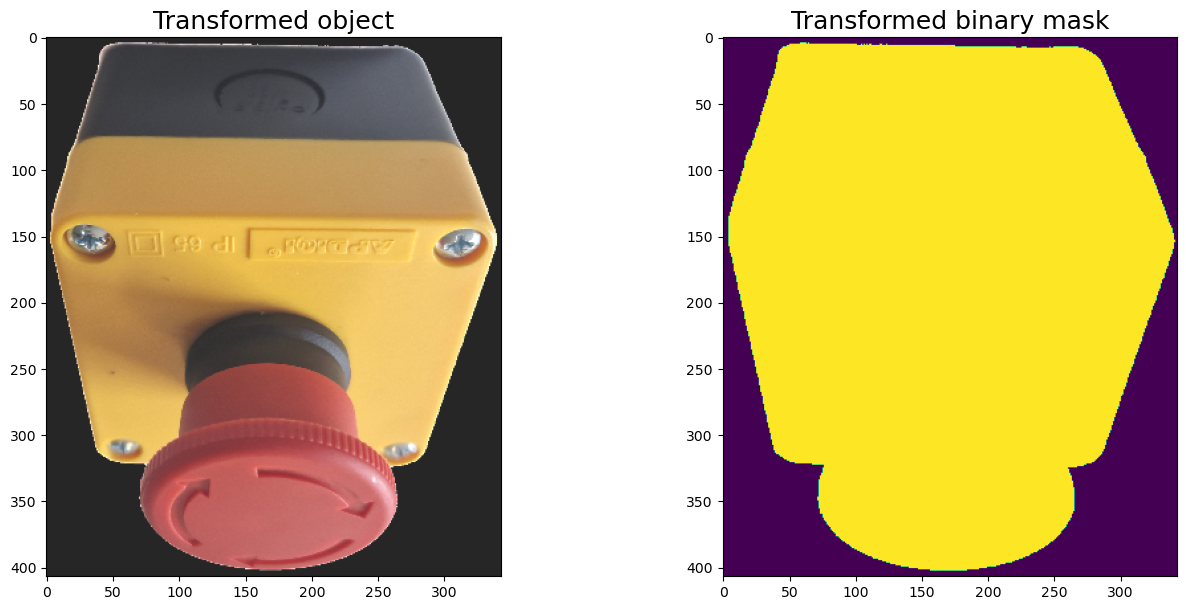

In [10]:
img_path = files_imgs[9]
mask_path = files_masks[9]
img, mask = get_img_and_mask(img_path, mask_path)

with open(files_keypoints[9]) as f:
    data = json.load(f)
    keypoints = data['keypoints']

img_t, mask_t, keypoints_t = resize_transform_obj(img,
                                                  mask,
                                                  longest_min=200,
                                                  longest_max=470,
                                                  keypoints=keypoints,
                                                  transforms=transforms_obj)

print("\nShape of the image of the transformed object:", img_t.shape)
print("Shape of the transformed binary mask:", img_t.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_t)
ax[0].set_title('Transformed object', fontsize=18)
ax[1].imshow(mask_t)
ax[1].set_title('Transformed binary mask', fontsize=18);

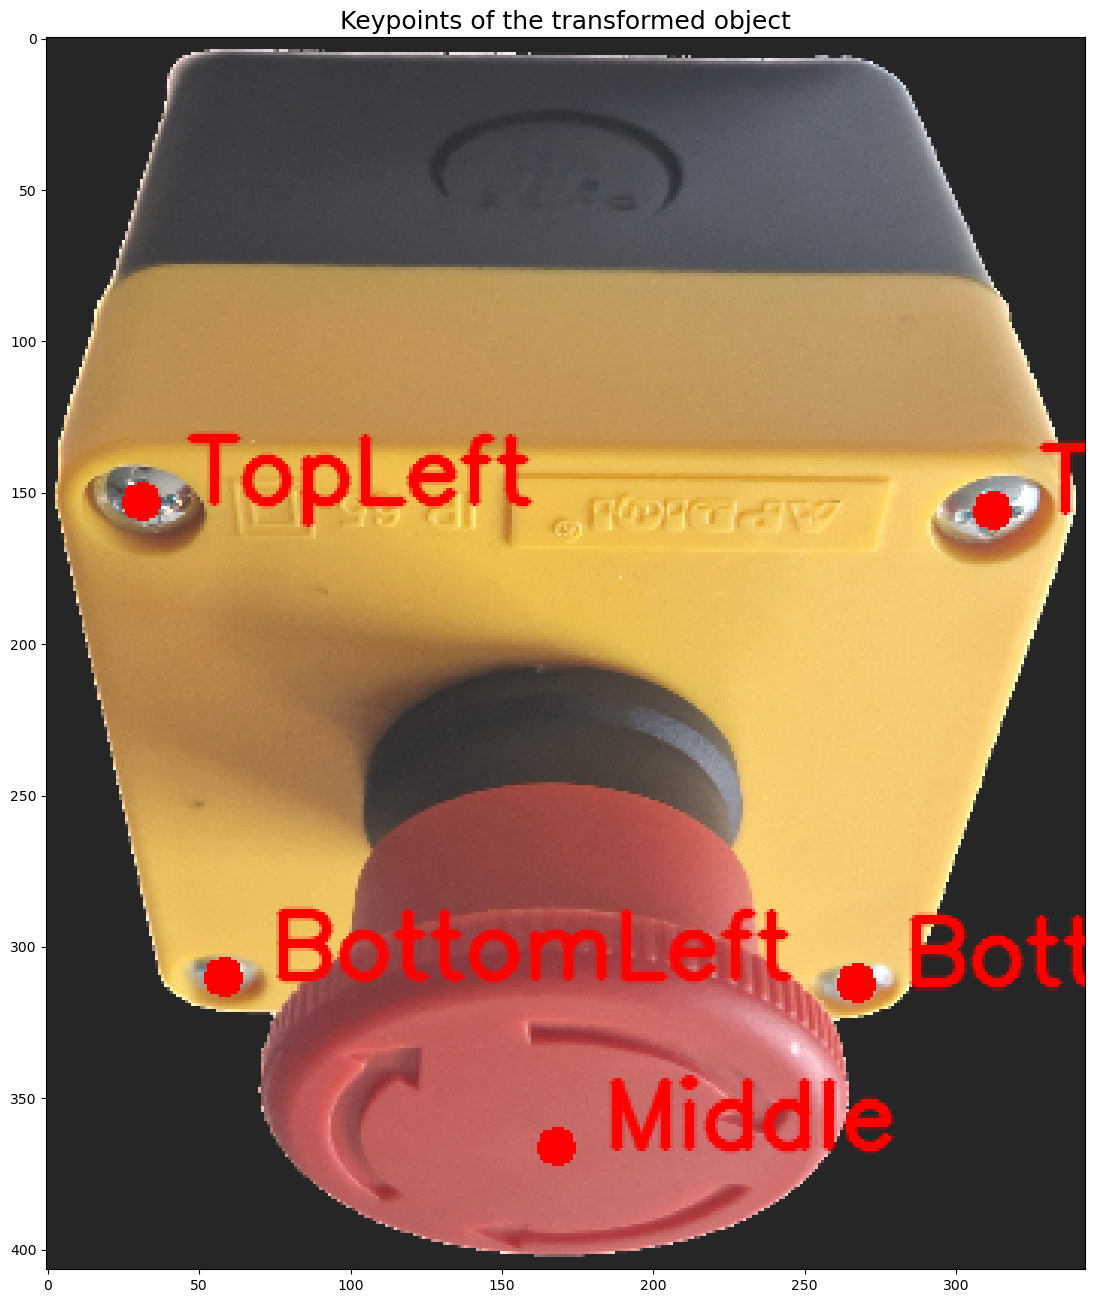

In [11]:
visualize_single_img_with_keypoints(img_t,
                                    mask_t,
                                    keypoints_t,
                                    keypoints_names,
                                    title="Keypoints of the transformed object")

In [12]:
def add_obj(img_comp, mask_comp, keypoints_comp, img, mask, keypoints, x, y, idx):
    '''
    img_comp - composition of objects
    mask_comp - composition of objects` masks
    keypoints_comp - composition of keypoints
    img - image of object
    mask - mask of object
    keypoints - keypoints of object
    x, y - coordinates where left top corner of img is placed
    Function returns img_comp in CV2 RGB format + mask_comp + keypoints_comp as a list
    '''
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]    
    h, w = img.shape[0], img.shape[1]   
    mask_b = mask == 1
    mask_rgb_b = np.stack([mask_b, mask_b, mask_b], axis=2)
    
    img_comp[y:y+h, x:x+w, :] = img_comp[y:y+h, x:x+w, :] * ~mask_rgb_b + (img * mask_rgb_b)
    mask_comp[y:y+h, x:x+w] = mask_comp[y:y+h, x:x+w] * ~mask_b + (idx * mask_b)
    keypoints_comp.append([[kp[0] + x, kp[1] + y, kp[2]] for kp in keypoints])
    
    return img_comp, mask_comp, keypoints_comp


def add_obj(img_comp, mask_comp, keypoints_comp, img, mask, keypoints, x, y, idx):
    '''
    img_comp - composition of objects
    mask_comp - composition of objects` masks
    keypoints_comp - composition of keypoints
    img - image of object
    mask - mask of object
    keypoints - keypoints of object
    x, y - coordinates where top-left corner of img is placed
    Function returns img_comp in CV2 RGB format + mask_comp + keypoints_comp as a list
    '''
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]    
    h, w = img.shape[0], img.shape[1]

    # Ensure that the object fits entirely within the composition
    if x < 0:
        img = img[:, -x:]
        mask = mask[:, -x:]
        keypoints = [[kp[0] - x, kp[1], kp[2]] for kp in keypoints]
        x = 0
    if y < 0:
        img = img[-y:, :]
        mask = mask[-y:, :]
        keypoints = [[kp[0], kp[1] - y, kp[2]] for kp in keypoints]
        y = 0
    if x + w > w_comp:
        img = img[:, :w_comp - x]
        mask = mask[:, :w_comp - x]
        keypoints = [[min(kp[0], w_comp - x), kp[1], kp[2]] for kp in keypoints]
    if y + h > h_comp:
        img = img[:h_comp - y, :]
        mask = mask[:h_comp - y, :]
        keypoints = [[kp[0], min(kp[1], h_comp - y), kp[2]] for kp in keypoints]

    mask_b = mask == 1
    mask_rgb_b = np.stack([mask_b, mask_b, mask_b], axis=2)
    
    img_comp[y:y+h, x:x+w, :] = img_comp[y:y+h, x:x+w, :] * ~mask_rgb_b + (img * mask_rgb_b)
    mask_comp[y:y+h, x:x+w] = mask_comp[y:y+h, x:x+w] * ~mask_b + (idx * mask_b)
    keypoints_comp.append([[kp[0] + x, kp[1] + y, kp[2]] for kp in keypoints])
    
    return img_comp, mask_comp, keypoints_comp

In [13]:
def visualize_composition_with_keypoints(img_comp, keypoints_comp, keypoints_names, bboxes_comp=None):
    
    if bboxes_comp:
        for bbox in bboxes_comp:
            start_point, end_point = tuple([bbox[0], bbox[1]]), tuple([bbox[2], bbox[3]])
            img_comp = cv2.rectangle(img_comp.copy(), start_point, end_point, (255,0,0), 2)
    
    for keypoints in keypoints_comp:
        for idx, kp in enumerate(keypoints):
            img_comp = cv2.circle(img_comp.copy(), tuple(kp[:2]), 3, (255,0,0), 6)
            img_comp = cv2.putText(img_comp.copy(), " " + keypoints_names[idx], tuple(kp[:2]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4, cv2.LINE_AA)
        
    plt.figure(figsize=(40,40))
    plt.imshow(img_comp)

Shape of img_bg: (480, 640, 3)
Shape of mask: (1077, 908)
Number of keypoints: 5


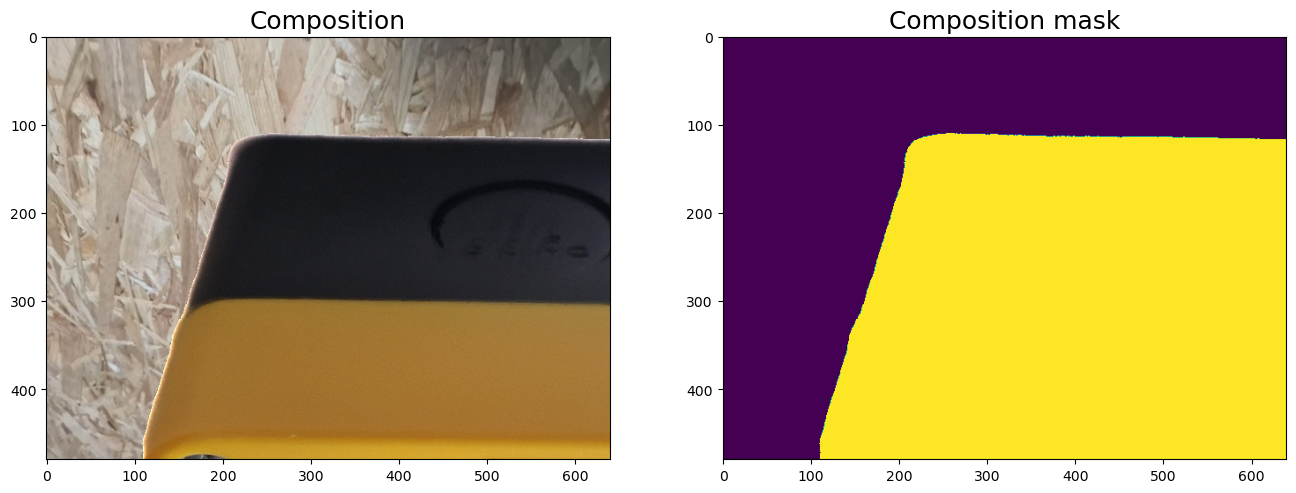

In [14]:
img_bg_path = files_bg_imgs[10]
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

h, w = img_bg.shape[0], img_bg.shape[1]
mask_comp = np.zeros((h,w), dtype=np.uint8)
keypoints_comp = []

print("Shape of img_bg:", img_bg.shape)
print("Shape of mask:", mask.shape)
print("Number of keypoints:", len(keypoints))

img_comp, mask_comp, keypoints_comp = add_obj(img_bg,
                                              mask_comp,
                                              keypoints_comp,
                                              img,
                                              mask,
                                              keypoints,
                                              x=100,
                                              y=100,
                                              idx=1)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18);

Keypoints: [[[184, 480, 1], [640, 480, 1], [254, 480, 1], [640, 480, 1], [547, 480, 1]]]


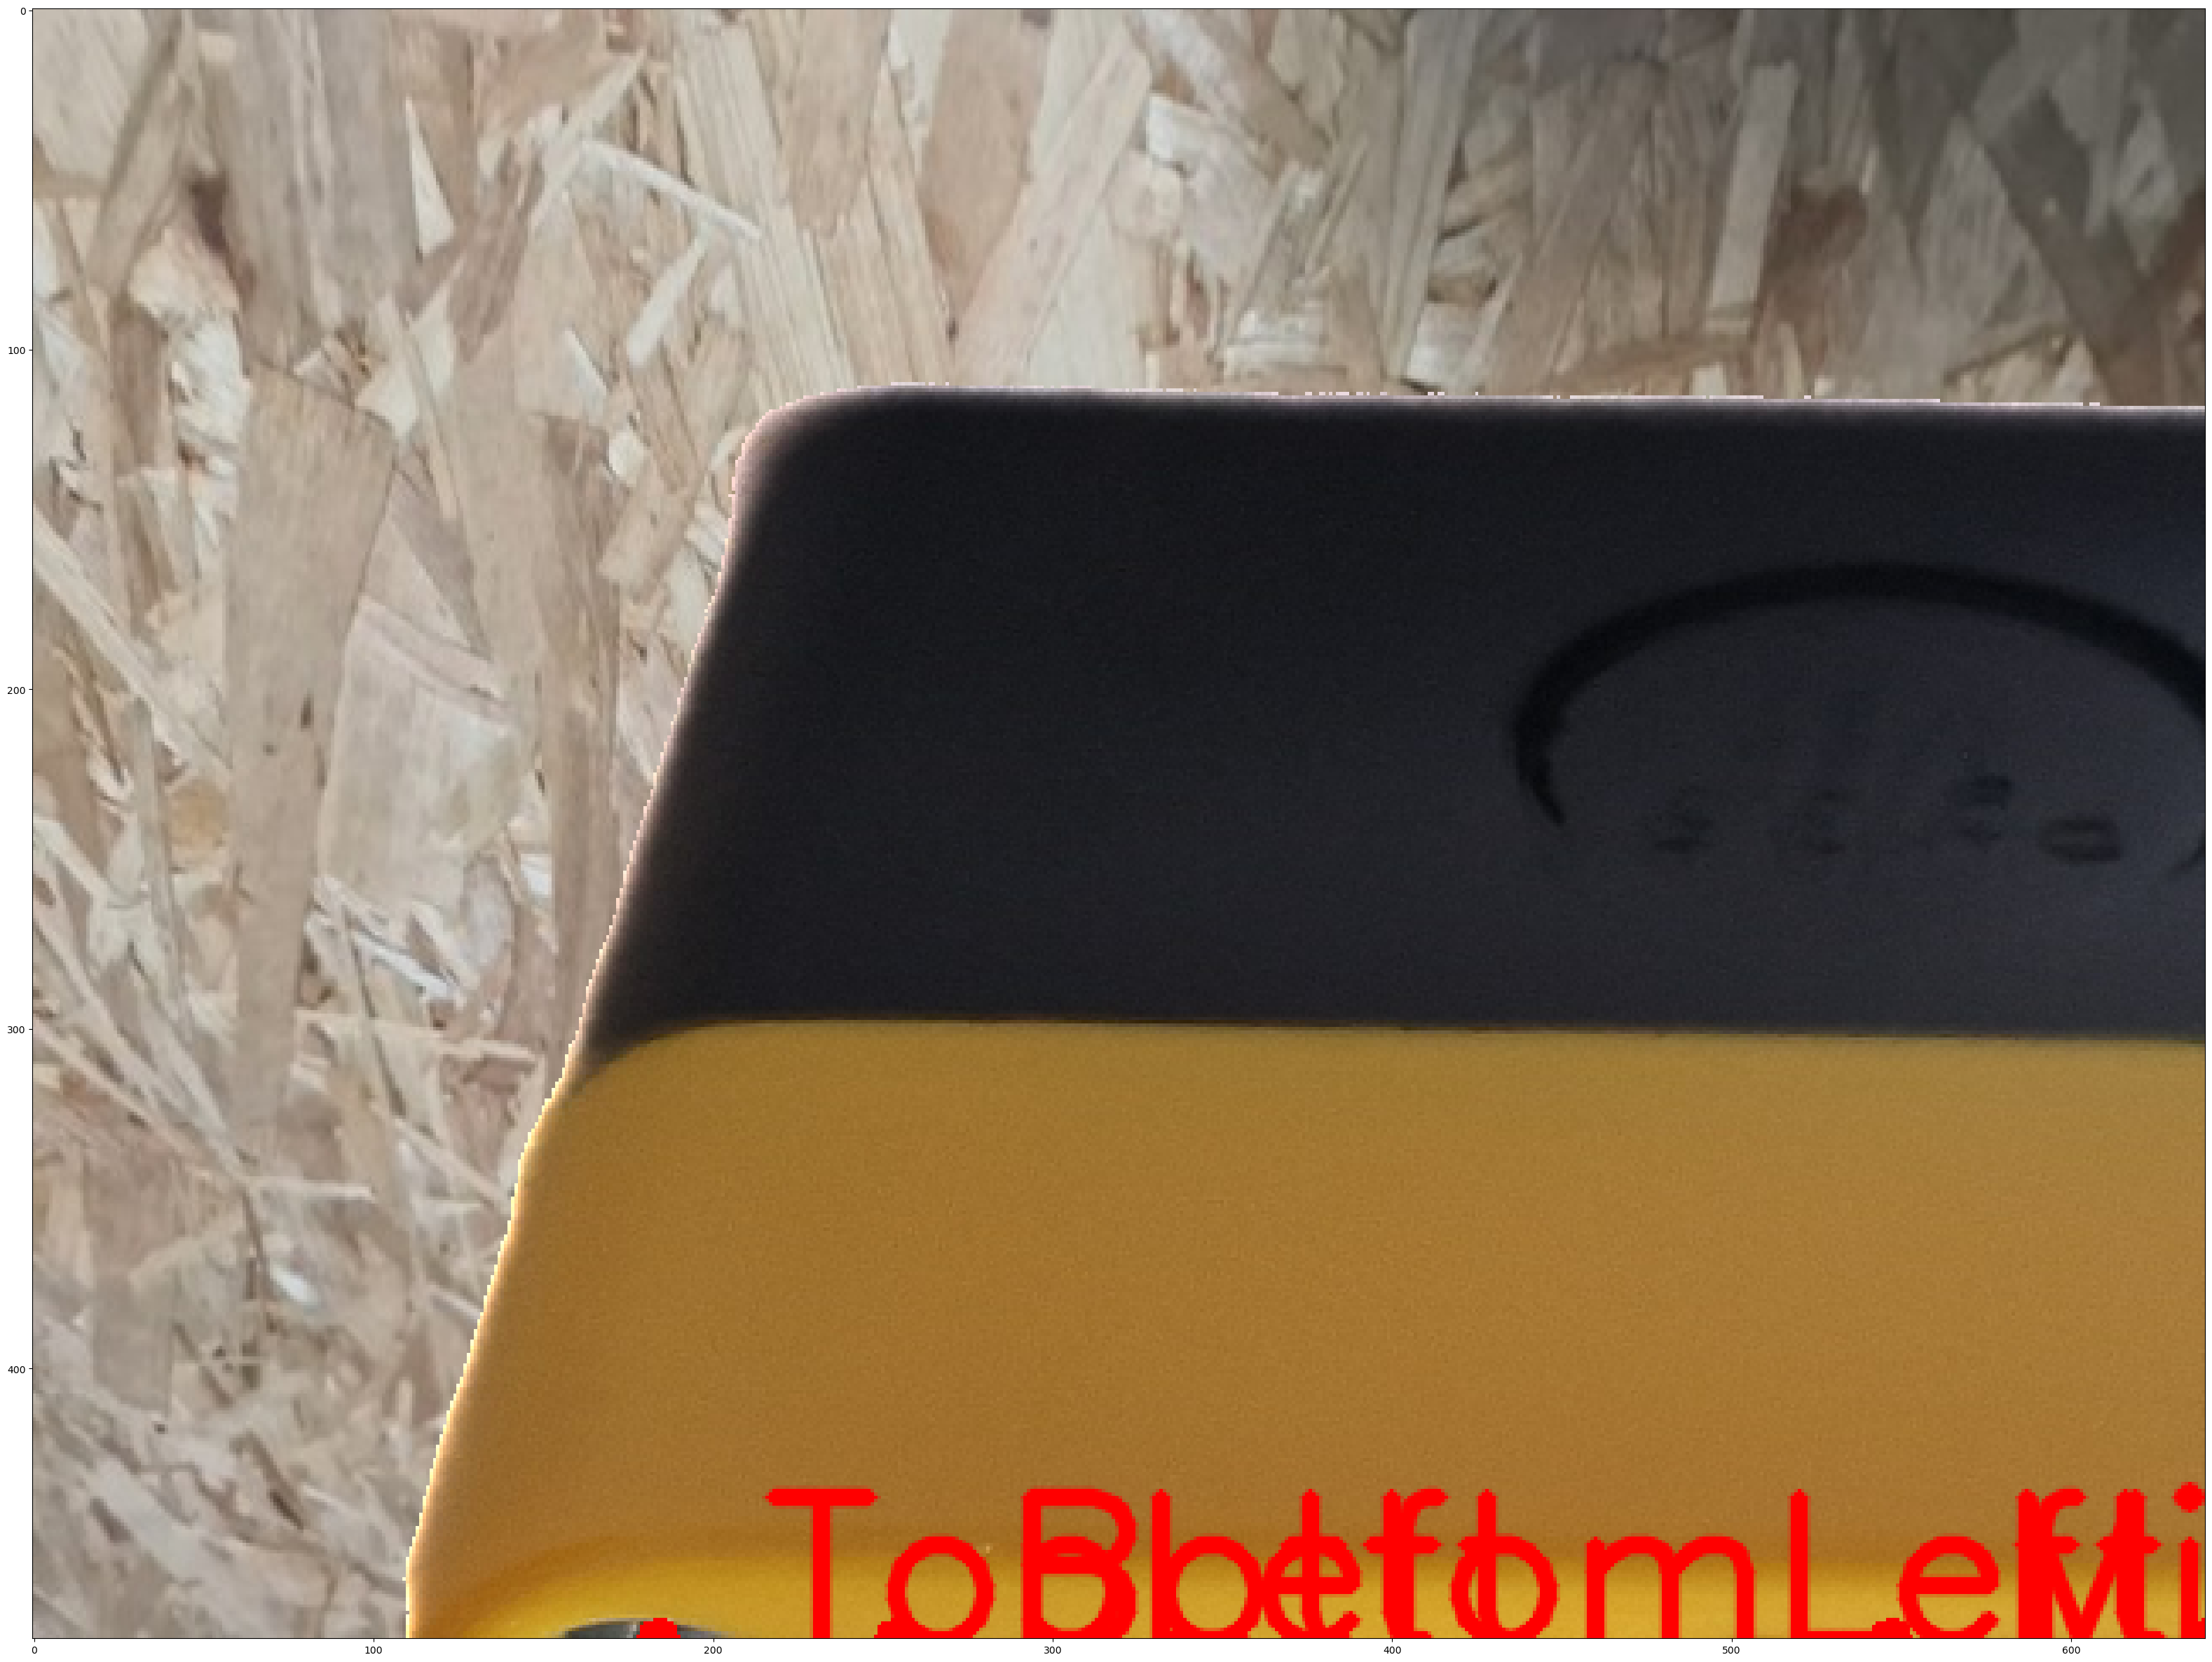

In [15]:
print("Keypoints:", keypoints_comp)
visualize_composition_with_keypoints(img_comp, keypoints_comp, keypoints_names)

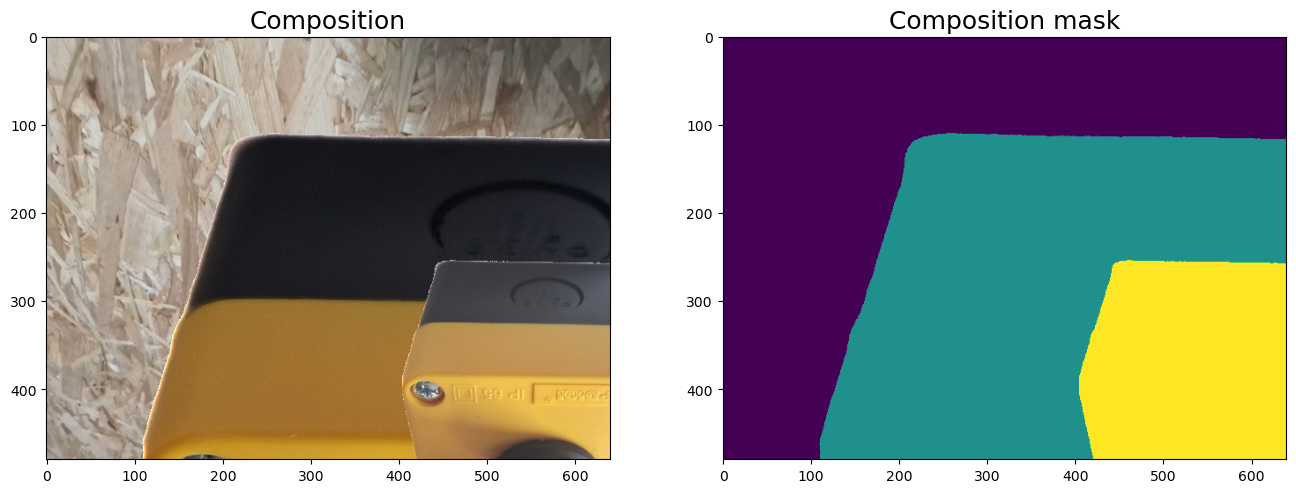

In [16]:

img_comp, mask_comp, keypoints_comp = add_obj(img_comp,
                                              mask_comp,
                                              keypoints_comp,
                                              img_t,
                                              mask_t,
                                              keypoints_t,
                                              x=400,
                                              y=250,
                                              idx=2)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18);

Keypoints: [[[184, 480, 1], [640, 480, 1], [254, 480, 1], [640, 480, 1], [547, 480, 1]], [[431, 403, 1], [640, 406, 1], [458, 480, 1], [640, 480, 1], [568, 480, 1]]]


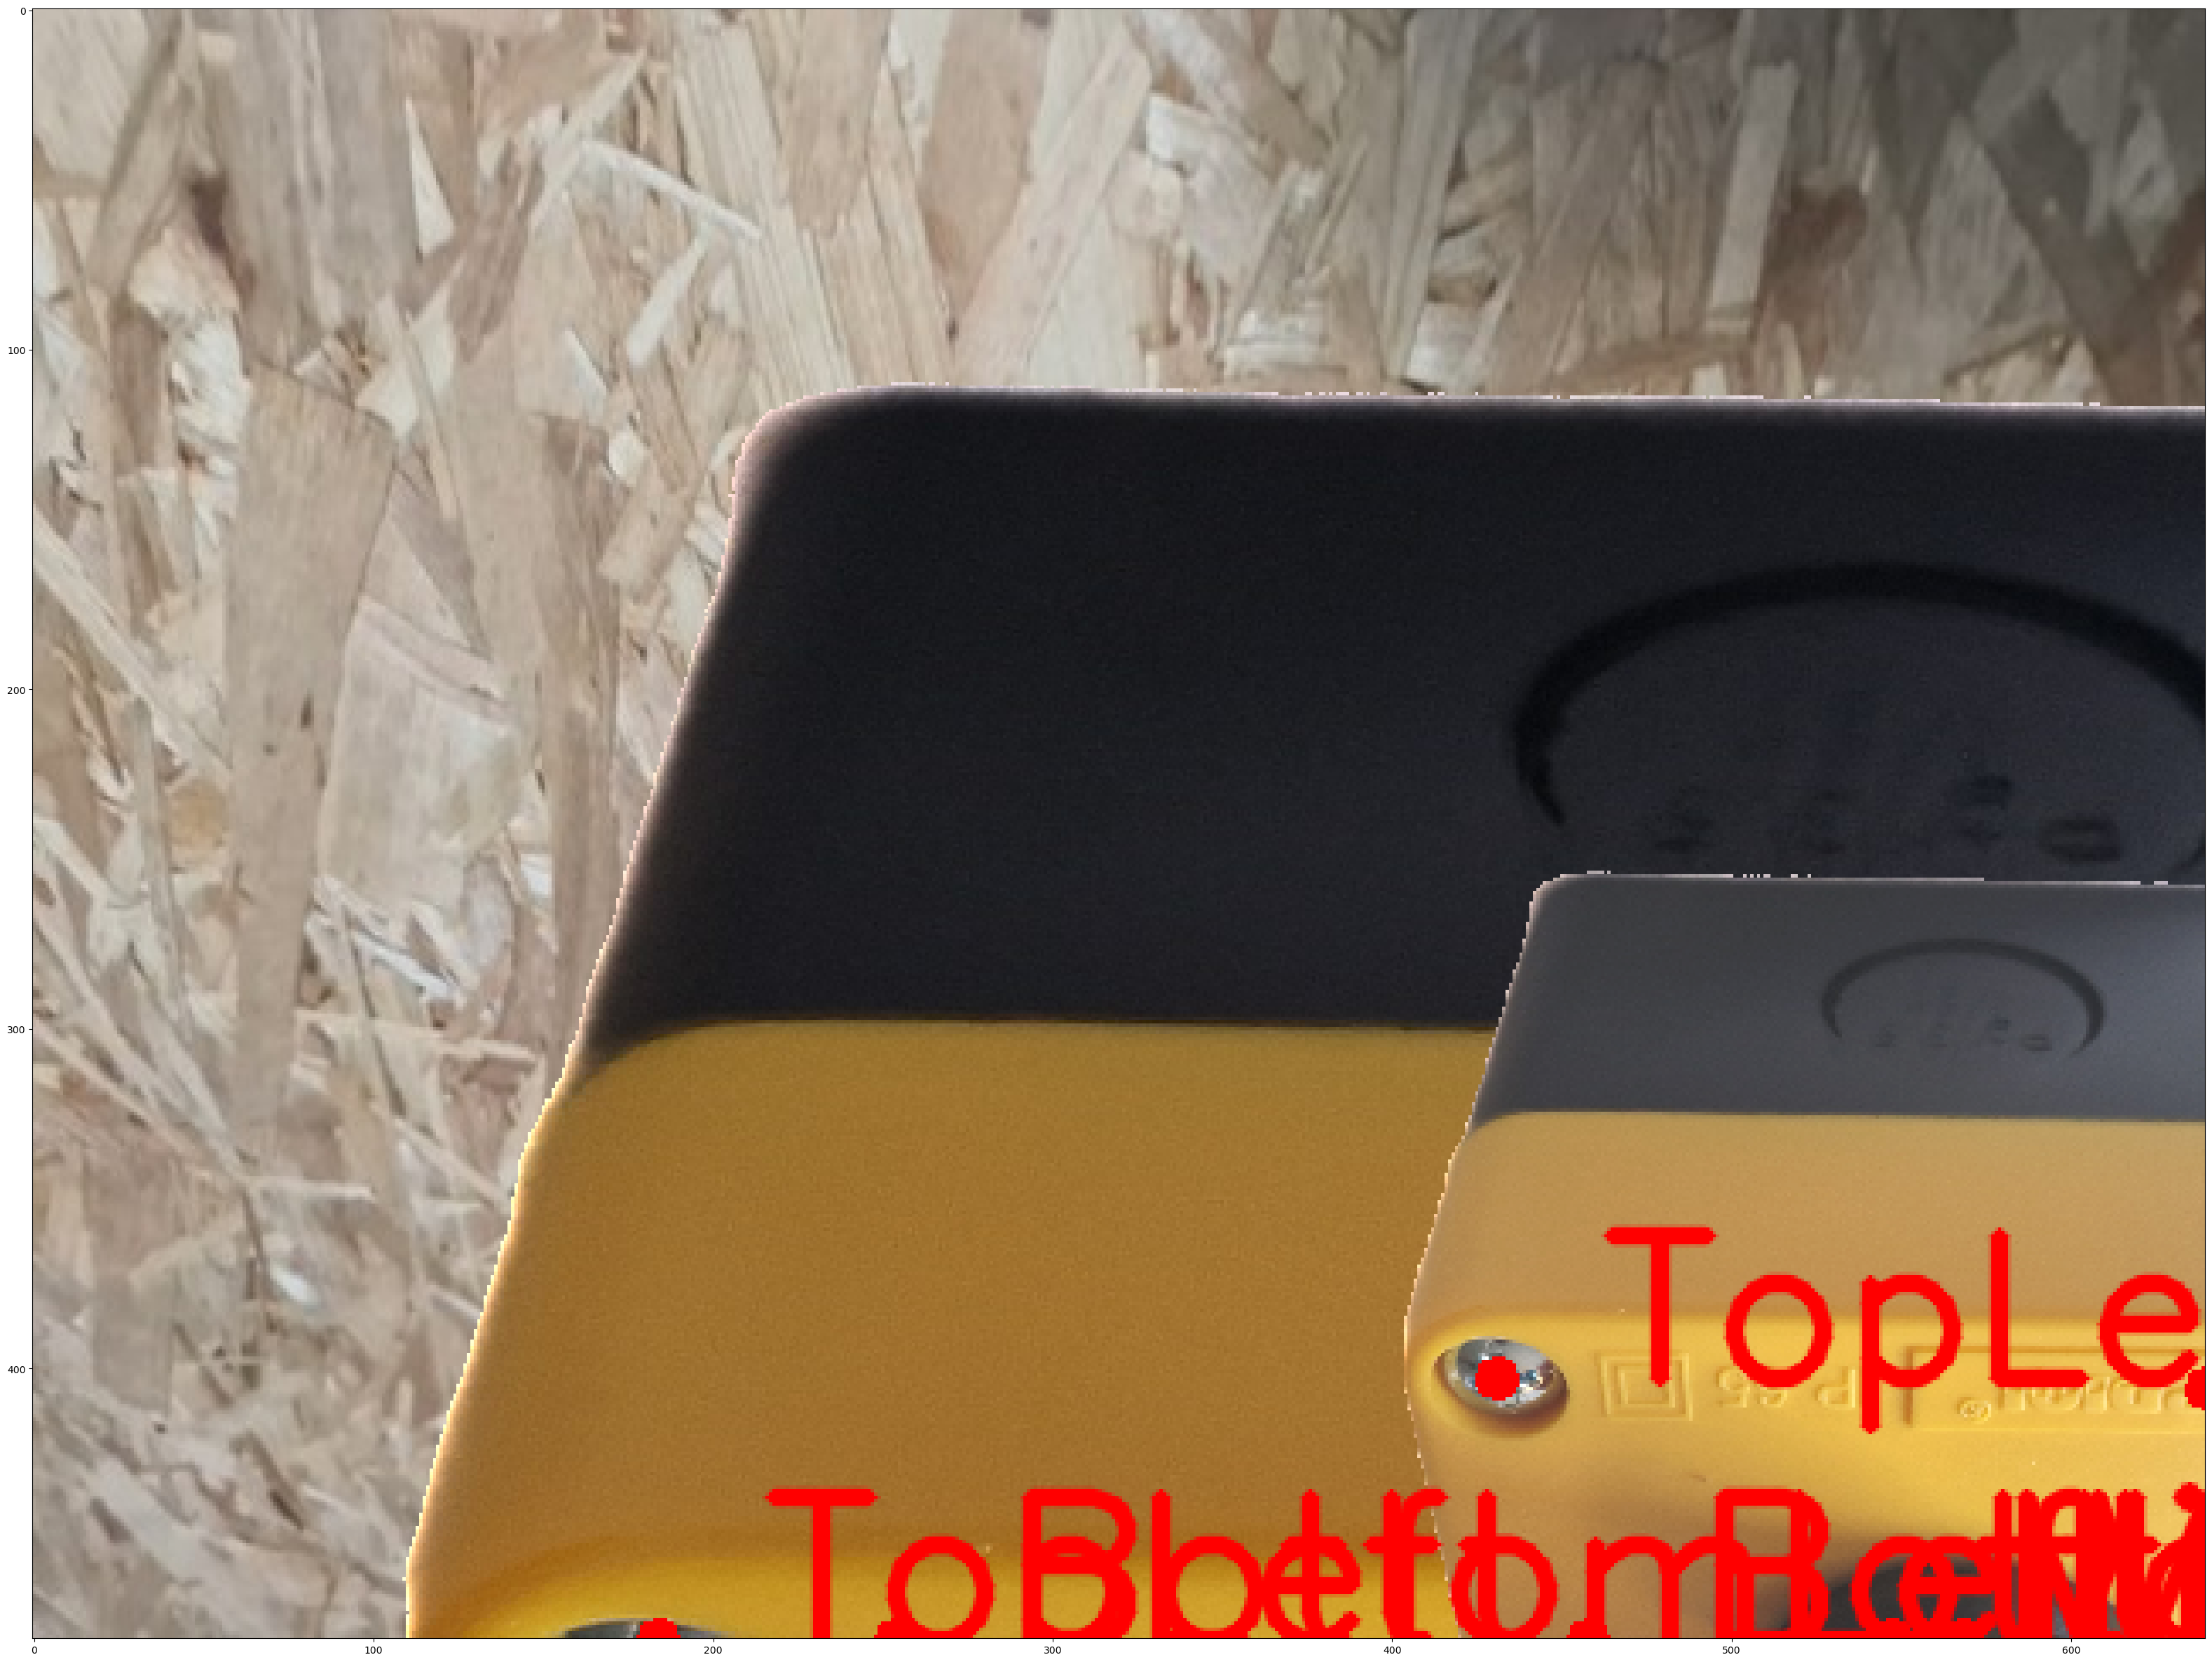

In [17]:
print("Keypoints:", keypoints_comp)
visualize_composition_with_keypoints(img_comp, keypoints_comp, keypoints_names)

In [18]:
def check_overlapping(mask_comp, obj_areas, overlap_degree=0):
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:-1]
    masks = mask_comp == obj_ids[:, None, None]
    
    ok = True
    
    if len(np.unique(mask_comp)) != np.max(mask_comp) + 1:
        ok = False
        return ok
    
    for idx, mask in enumerate(masks):
        if np.count_nonzero(mask) / obj_areas[idx] < 1 - overlap_degree:
            ok = False
            break
            
    return ok

In [19]:
def create_composition(img_comp_bg,
                       max_objs=15,
                       longest_min=300,
                       longest_max=700,
                       overlap_degree=0,
                       max_attempts_per_obj=10):

    img_comp = img_comp_bg.copy()
    h, w = img_comp.shape[0], img_comp.shape[1]
    mask_comp = np.zeros((h,w), dtype=np.uint8)
    keypoints_comp = []
    
    obj_areas = []
    num_objs = np.random.randint(max_objs) + 2
    
    i = 1
    
    for _ in range(1, num_objs):
       
        for _ in range(max_attempts_per_obj):

            imgs_number = len(files_imgs)
            idx = np.random.randint(imgs_number)
            
            img_path = files_imgs[idx]
            mask_path = files_masks[idx]
            keypoints_path = files_keypoints[idx]
            
            img, mask = get_img_and_mask(img_path, mask_path)
            with open(keypoints_path) as f:
                data = json.load(f)
                keypoints = data['keypoints']
                
            img_t, mask_t, keypoints_t = resize_transform_obj(img,
                                                              mask,
                                                              longest_min,
                                                              longest_max,
                                                              keypoints=keypoints,
                                                              transforms=transforms_obj)
            x_max, y_max = img_comp.shape[1] - img_t.shape[1], img_comp.shape[0] - img_t.shape[0]
            x, y = np.random.randint(x_max), np.random.randint(y_max)

            if i == 1:
                img_comp, mask_comp, keypoints_comp = add_obj(img_comp,
                                                              mask_comp,
                                                              keypoints_comp,
                                                              img_t,
                                                              mask_t,
                                                              keypoints_t,
                                                              x,
                                                              y,
                                                              i)
                obj_areas.append(np.count_nonzero(mask_t))
                i += 1
                break
            else:        
                img_comp_prev, mask_comp_prev, keypoints_comp_prev = img_comp.copy(), mask_comp.copy(), keypoints_comp.copy()
                img_comp, mask_comp, keypoints_comp = add_obj(img_comp,
                                                              mask_comp,
                                                              keypoints_comp,
                                                              img_t,
                                                              mask_t,
                                                              keypoints_t,
                                                              x,
                                                              y,
                                                              i)
                ok = check_overlapping(mask_comp, obj_areas, overlap_degree)
                if ok:
                    obj_areas.append(np.count_nonzero(mask_t))
                    i += 1
                    break
                else:
                    img_comp, mask_comp, keypoints_comp = img_comp_prev.copy(), mask_comp_prev.copy(), keypoints_comp_prev.copy()
        
    return img_comp, mask_comp, keypoints_comp

In [20]:
def create_bboxes_from_mask_comp(mask_comp):
    
    height, width = mask_comp.shape[0], mask_comp.shape[1]
    
    obj_ids = np.unique(mask_comp)[1:]
    masks = mask_comp == obj_ids[:, None, None]

    bboxes_comp = []
    
    for i in range(len(obj_ids)):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        bboxes_comp.append(list(map(int, [xmin, ymin, xmax, ymax])))

    return bboxes_comp

Keypoints: [[[184, 480, 1], [640, 480, 1], [254, 480, 1], [640, 480, 1], [547, 480, 1]], [[431, 403, 1], [640, 406, 1], [458, 480, 1], [640, 480, 1], [568, 480, 1]]]


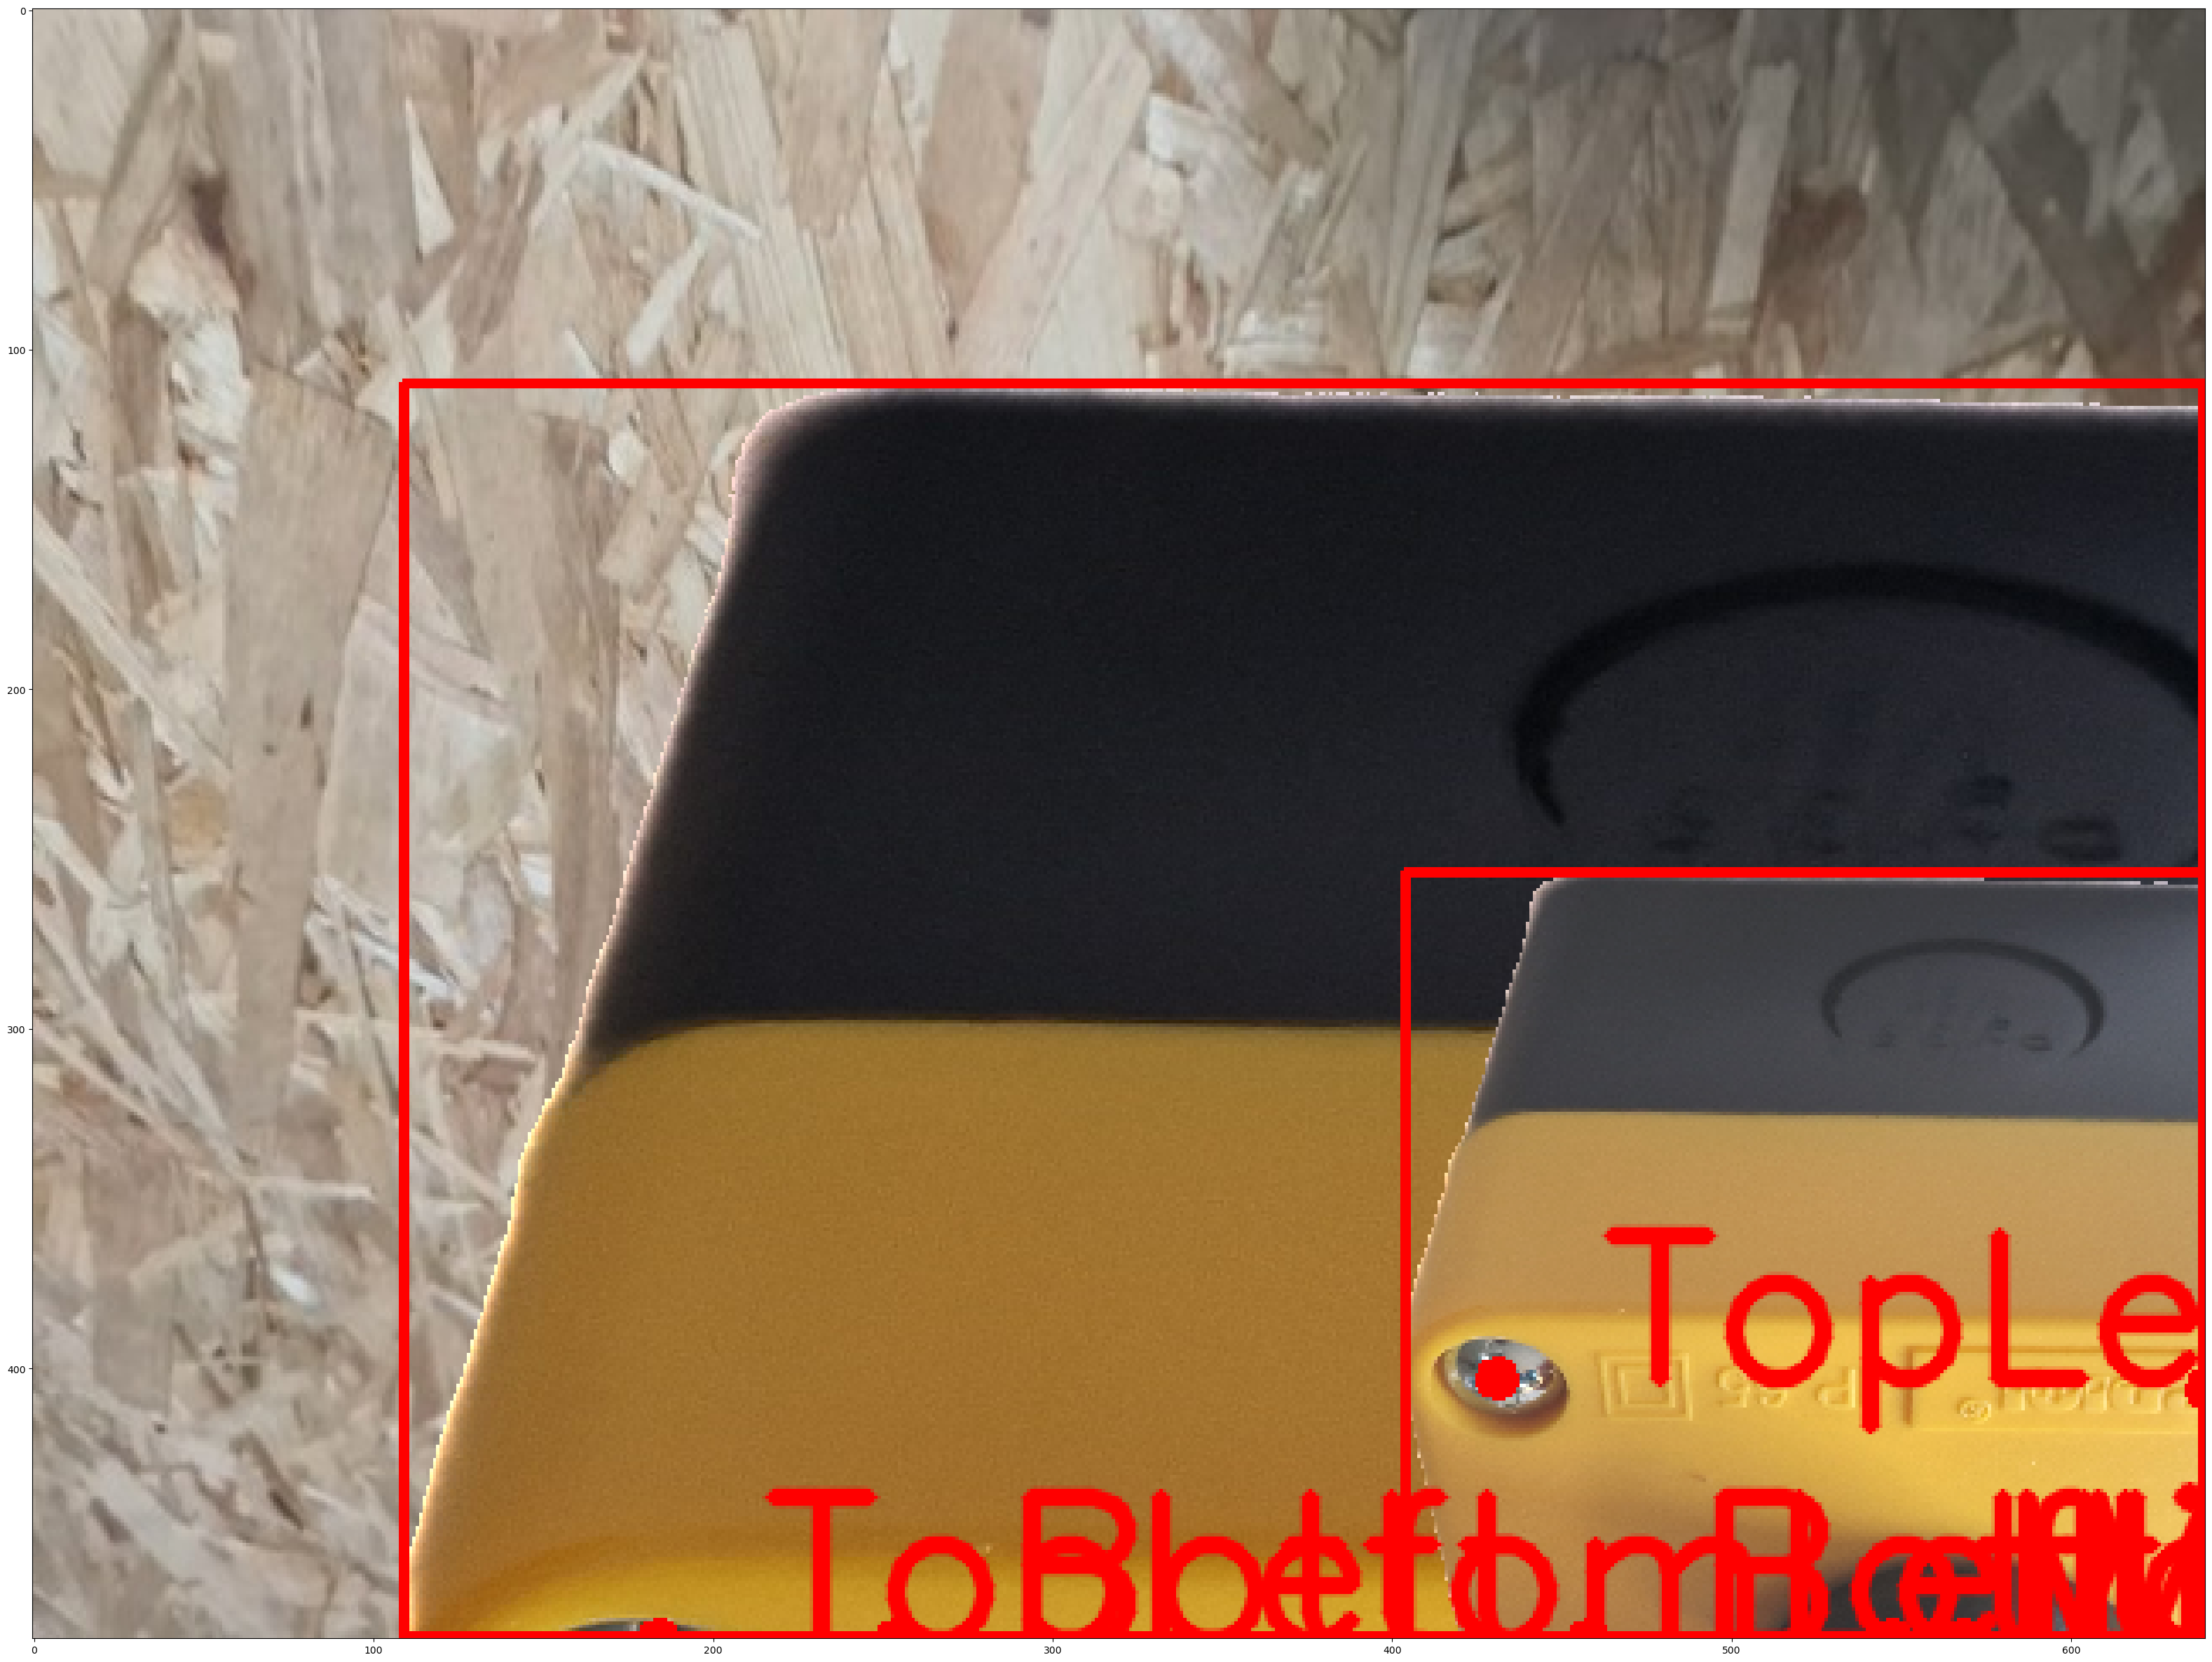

In [21]:
print("Keypoints:", keypoints_comp)

bboxes_comp = create_bboxes_from_mask_comp(mask_comp)

visualize_composition_with_keypoints(img_comp,
                                     keypoints_comp,
                                     keypoints_names,
                                     bboxes_comp)

In [22]:
def generate_dataset(imgs_number, folder, split='train'):
    time_start = time.time()
    for j in tqdm(range(imgs_number)):
        # img_comp_bg = create_bg_with_noise(files_bg_imgs,
        #                                    files_bg_noise_imgs,
        #                                    files_bg_noise_masks,
        #                                    max_objs_to_add=60)

        # We skipped background noise object for now - skpawar1305
        idx = np.random.randint(len(files_bg_imgs))
        img_comp_bg = cv2.imread(files_bg_imgs[idx])
        img_comp_bg = cv2.cvtColor(img_comp_bg, cv2.COLOR_BGR2RGB)

        img_comp, mask_comp, keypoints_comp = create_composition(img_comp_bg, max_objs=1,
                                                                 overlap_degree=0,
                                                                 max_attempts_per_obj=1,
                                                                 longest_min=20,
                                                                 longest_max=470)
        bboxes_comp = create_bboxes_from_mask_comp(mask_comp)

        # Create subfolders for 'images' and 'annotations'
        image_folder = os.path.join(folder, 'images', split)
        annotation_folder = os.path.join(folder, 'annotations', split)

        os.makedirs(image_folder, exist_ok=True)
        os.makedirs(annotation_folder, exist_ok=True)

        img_comp = cv2.cvtColor(img_comp, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(image_folder, '{}.jpg').format(j), img_comp)

        annotations = {}
        annotations['bboxes'], annotations['keypoints'] = bboxes_comp, keypoints_comp
        with open(os.path.join(annotation_folder, '{}.json').format(j), "w") as f:
            json.dump(annotations, f)

    time_end = time.time()
    time_total = round(time_end - time_start)
    time_per_img = round((time_end - time_start) / imgs_number, 1)
    
    print("Generation of {} synthetic images is completed. It took {} seconds, or {} seconds per image".format(imgs_number, time_total, time_per_img))
    print("Images are stored in '{}'".format(os.path.join(folder, split, 'images')))
    print("Annotations are stored in '{}'".format(os.path.join(folder, split, 'annotations')))

In [23]:
generate_dataset(4000, folder='dataset', split='train')
generate_dataset(800, folder='dataset', split='val')

100%|██████████| 4000/4000 [02:50<00:00, 23.44it/s]


Generation of 4000 synthetic images is completed. It took 171 seconds, or 0.0 seconds per image
Images are stored in 'dataset/train/images'
Annotations are stored in 'dataset/train/annotations'


100%|██████████| 800/800 [00:33<00:00, 23.95it/s]

Generation of 800 synthetic images is completed. It took 33 seconds, or 0.0 seconds per image
Images are stored in 'dataset/val/images'
Annotations are stored in 'dataset/val/annotations'


In [24]:
def convert_bbox_to_yolo(size, box):
    dw = 1.0 / (size[1])
    dh = 1.0 / (size[0])
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = box[0] + w / 2.0
    y = box[1] + h / 2.0
    # The round function determines the number of decimal places in (xmin, ymin, xmax, ymax)
    x = round(x * dw, 6)
    w = round(w * dw, 6)
    y = round(y * dh, 6)
    h = round(h * dh, 6)
    return (x, y, w, h)


def convert_keypoints_to_yolo(size, keypoints):
    dw = 1.0 / (size[1])
    dh = 1.0 / (size[0])
    final = []
    for point in keypoints:
        x = point[0]
        y = point[1]
        x = round(x * dw, 6)
        y = round(y * dh, 6)
        final.extend([x, y])
        # YOLOV5 = True
        # if YOLOV5:
        #     final.append(2)
    return final


def write_labels(json_files, data="train"):
    for json_file in json_files:
        with open(f"dataset/annotations/{data}/{json_file}") as f:
            annotation_content = json.load(f)

        img = cv2.imread(f"dataset/images/{data}/{json_file.strip('.json')}.jpg")
        bbox = convert_bbox_to_yolo((img.shape), annotation_content["bboxes"][0])
        keypoints = convert_keypoints_to_yolo(img.shape, annotation_content["keypoints"][0])
        final_string = "0 " + str(bbox).replace(',', '').strip('()') + " " + str(keypoints).replace(',', '').strip('[]')

        with open(f"dataset/labels/{data}/{json_file.strip('.json')}.txt", "w") as f:
            f.write(final_string)


os.makedirs("dataset/labels/train", exist_ok=True)
json_files = os.listdir("dataset/annotations/train")
write_labels(json_files, "train")

os.makedirs("dataset/labels/val", exist_ok=True)
json_files = os.listdir("dataset/annotations/val")
write_labels(json_files, "val")

In [25]:
config = """# Data
train: images/train
val: images/val

# Keypoints
kpt_shape: [5, 2]
flip_idx: [1, 0, 3, 2, 4]

# Classes
names:
 0: estop
"""

with open("dataset/config.yaml", 'w') as f:
    f.write(config)

In [26]:
# Blur 30% images

import random


# Function to apply motion blur to an image
def apply_motion_blur(image, angle=0):
    kernel_size = random.randint(5, 20)  # Random kernel size between 5 and 20
    motion_blur_kernel = np.zeros((kernel_size, kernel_size))
    motion_blur_kernel[int((kernel_size-1)/2), :] = 1.0 / kernel_size
    return cv2.warpAffine(cv2.filter2D(image, -1, motion_blur_kernel), 
                          cv2.getRotationMatrix2D((kernel_size/2, kernel_size/2), angle, 1), image.shape[1::-1])


# Function to apply random JPEG compression to an image
def apply_random_jpeg_compression(image):
    quality = random.randint(1, 30)  # Random JPEG quality between 1 and 30
    _, encoded_image = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    return cv2.imdecode(encoded_image, 1)


def modify_images(input_folder):
    # Specify the folder containing your images
    input_folder = input_folder + '/'

    # List all image filenames in the input folder
    all_images = os.listdir(input_folder)
    all_images = [input_folder + image for image in all_images]

    # Calculate the number of images to process (30% of total images)
    num_images_to_process = int(0.3 * len(all_images))
    random_images = random.sample(all_images, num_images_to_process)

    for random_image in random_images:
        image = cv2.imread(random_image)
        image = apply_motion_blur(image)
        image = apply_random_jpeg_compression(image)
        cv2.imwrite(random_image, image)


modify_images('dataset/images/train')
modify_images('dataset/images/val')

In [27]:
# from ultralytics import YOLO

# # Load a model
# model = YOLO('yolov8n-pose.yaml')  # build a new model from YAML
# model = YOLO('yolov8n-pose.pt')  # load a pretrained model (recommended for training)
# model = YOLO('yolov8n-pose.yaml').load('yolov8n-pose.pt')  # build from YAML and transfer weights

# # Train the model
# results = model.train(data=f'{os.getcwd()}/dataset/config.yaml', epochs=200, imgsz=640)